In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots

# torch.set_printoptions(precision=8, sci_mode=False, edgeitems=5)
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)

matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots

from tueplots import bundles, fontsizes, figsizes

from wbml import experiment, out, plot

In [45]:
dataset = "Adult"
pvi_type = "Seq"

exps = {'mfvi': "draft_results/Adult/Seq/07-24-10.12.05_seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi", 
        'gi': "draft_results/Adult/Seq/07-24-10.11.10_seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight"}

In [46]:
for k, e in exps.items():
    main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    exps[k] = os.path.join(main_dir, e, "metrics")

In [47]:
logs = {}
for k, e in exps.items():
    logs[k] = {}
    for log_name in os.listdir(e):
        
        name = log_name.split('_')[0]
        logs[k][name] = pd.read_csv(os.path.join(e, log_name))
        
        logs[k][name]['pvi'] = pvi_type.upper()
        logs[k][name]['variational'] = k.upper()


In [48]:
logs['mfvi'].keys()

dict_keys(['client4', 'client9', 'client7', 'client3', 'server', 'client8', 'client0', 'client2', 'client6', 'client1', 'client5'])

In [75]:
mfvi_server: pd.DataFrame = logs['mfvi']['server']
gi_server: pd.DataFrame = logs['gi']['server']

,communications,iteration,train_mll,train_acc,test_mll,test_acc,pvi,variational
0,0,0,-0.693148,0.238477,-0.693150,0.242527,SEQ,MFVI
1,2,1,-0.693160,0.238477,-0.693158,0.242527,SEQ,MFVI
2,4,2,-0.691551,0.761523,-0.691584,0.757473,SEQ,MFVI
3,6,3,-0.688803,0.761523,-0.688873,0.757473,SEQ,MFVI
4,8,4,-0.682042,0.761523,-0.682218,0.757473,SEQ,MFVI
...,...,...,...,...,...,...,...,...
96,192,96,-0.323429,0.854452,-0.330766,0.848792,SEQ,MFVI
97,194,97,-0.325679,0.853351,-0.333341,0.850532,SEQ,MFVI
98,196,98,-0.325840,0.853479,-0.334433,0.847973,SEQ,MFVI
99,198,99,-0.325509,0.853659,-0.332908,0.847973,SEQ,MFVI


Merge dataframes for plotting purposes.

In [76]:
server = pd.concat([gi_server, mfvi_server], ignore_index=True)

Plot test mll and accuracy

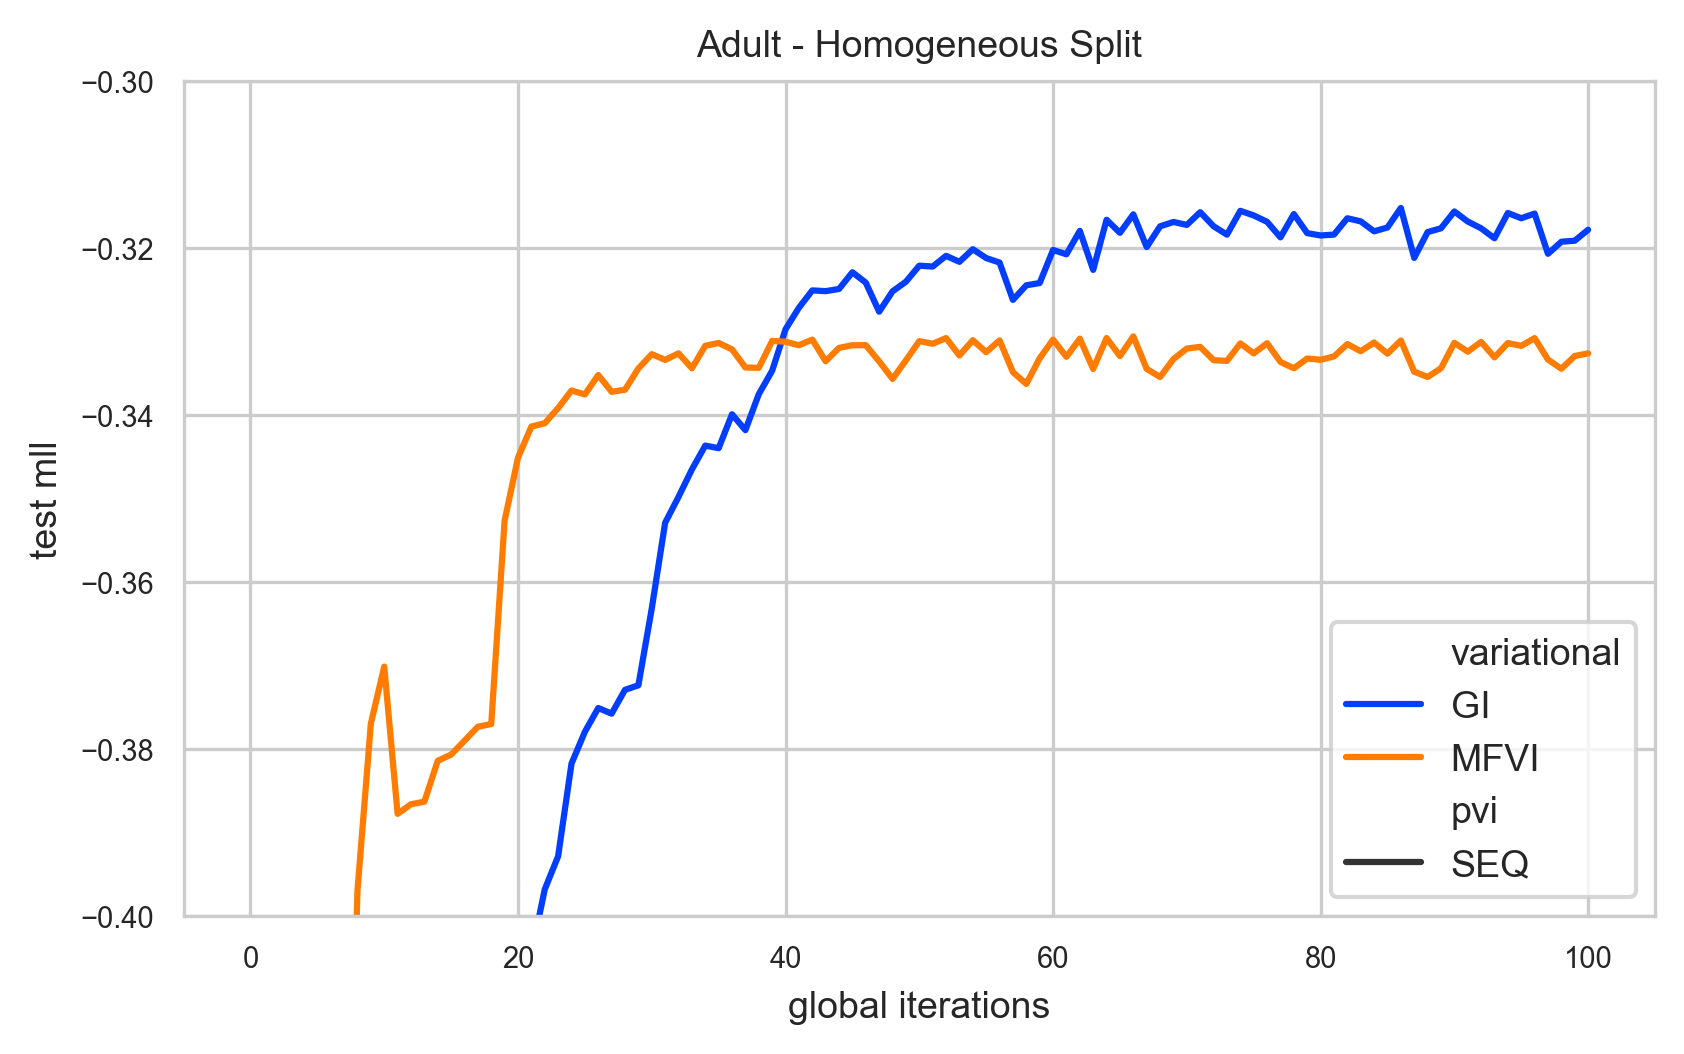

In [68]:

with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    sns.lineplot(data=server, x='iteration', y='test_mll', ax=ax, hue='variational', style='pvi')
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    ax.set_ylim((-0.40, -0.30))
    ax.set_ylabel('test mll')
    ax.set_xlabel('global iterations')
    ax.legend(loc="lower right", prop={"size": 9})
    plt.show()

Accuracy

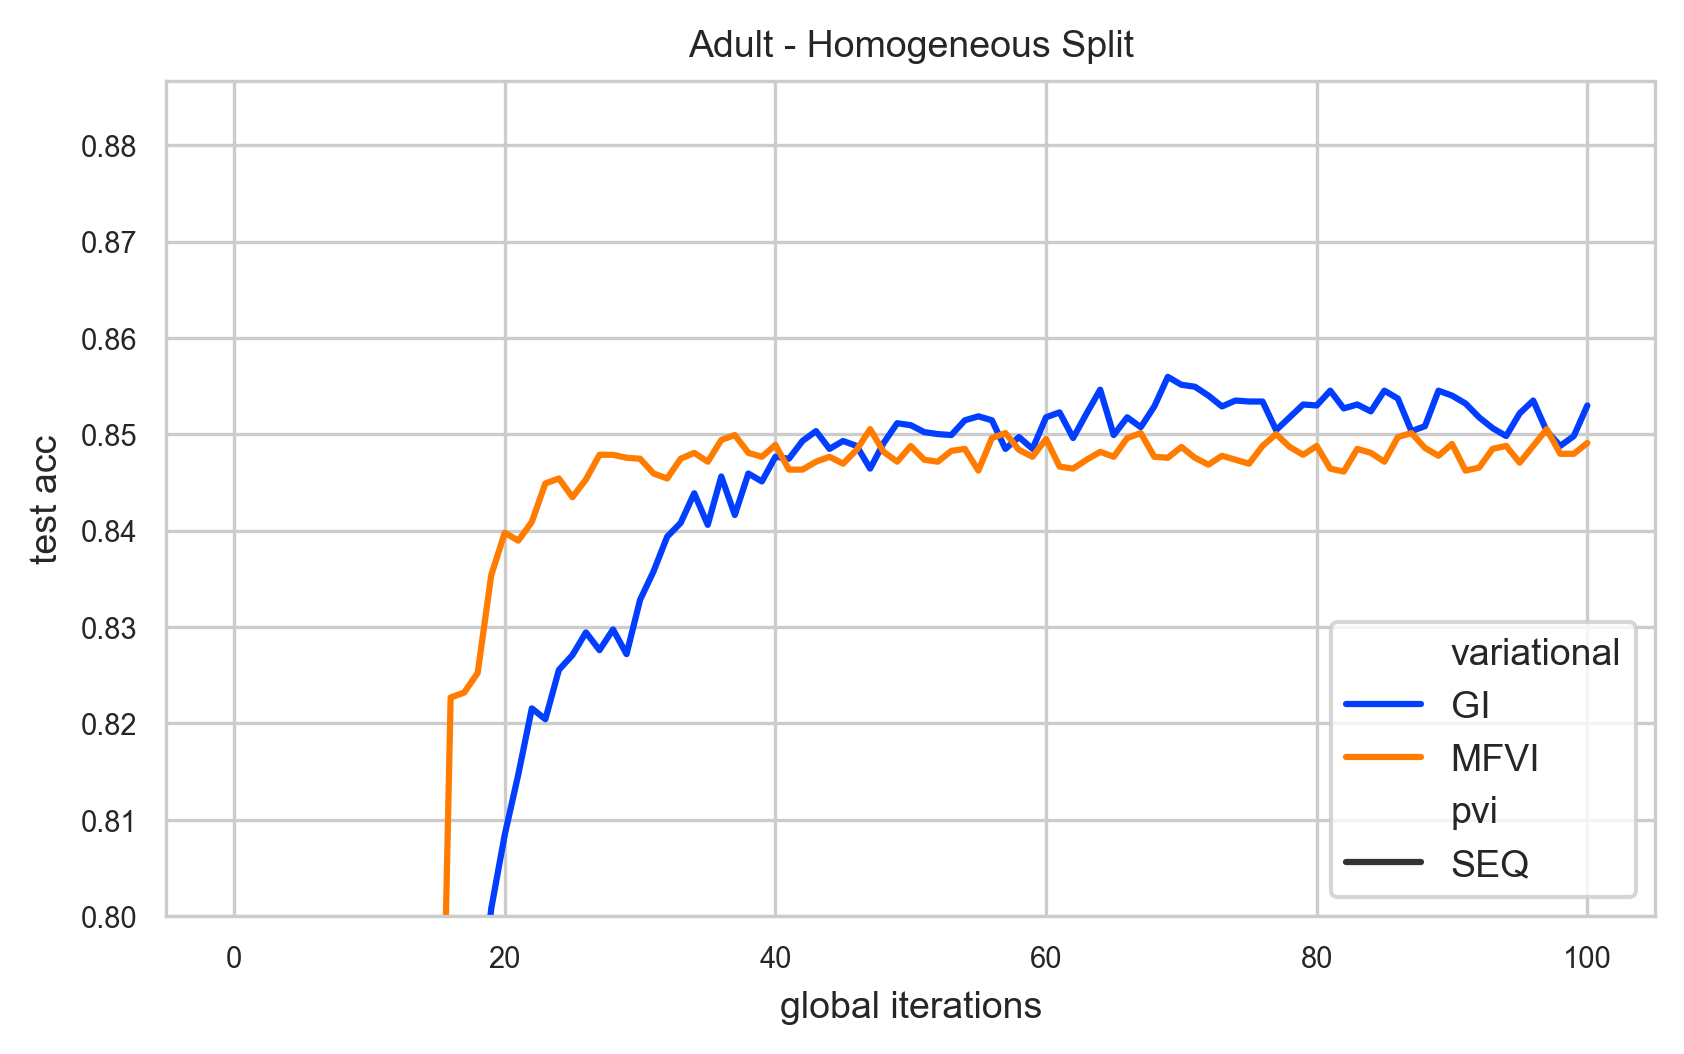

In [79]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    sns.lineplot(data=server, x='iteration', y='test_acc', ax=ax, hue='variational', style='pvi')
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    ax.set_ylim((0.80))
    ax.set_ylabel('test acc')
    ax.set_xlabel('global iterations')
    ax.legend(loc="lower right", prop={"size": 9})
    plt.show()

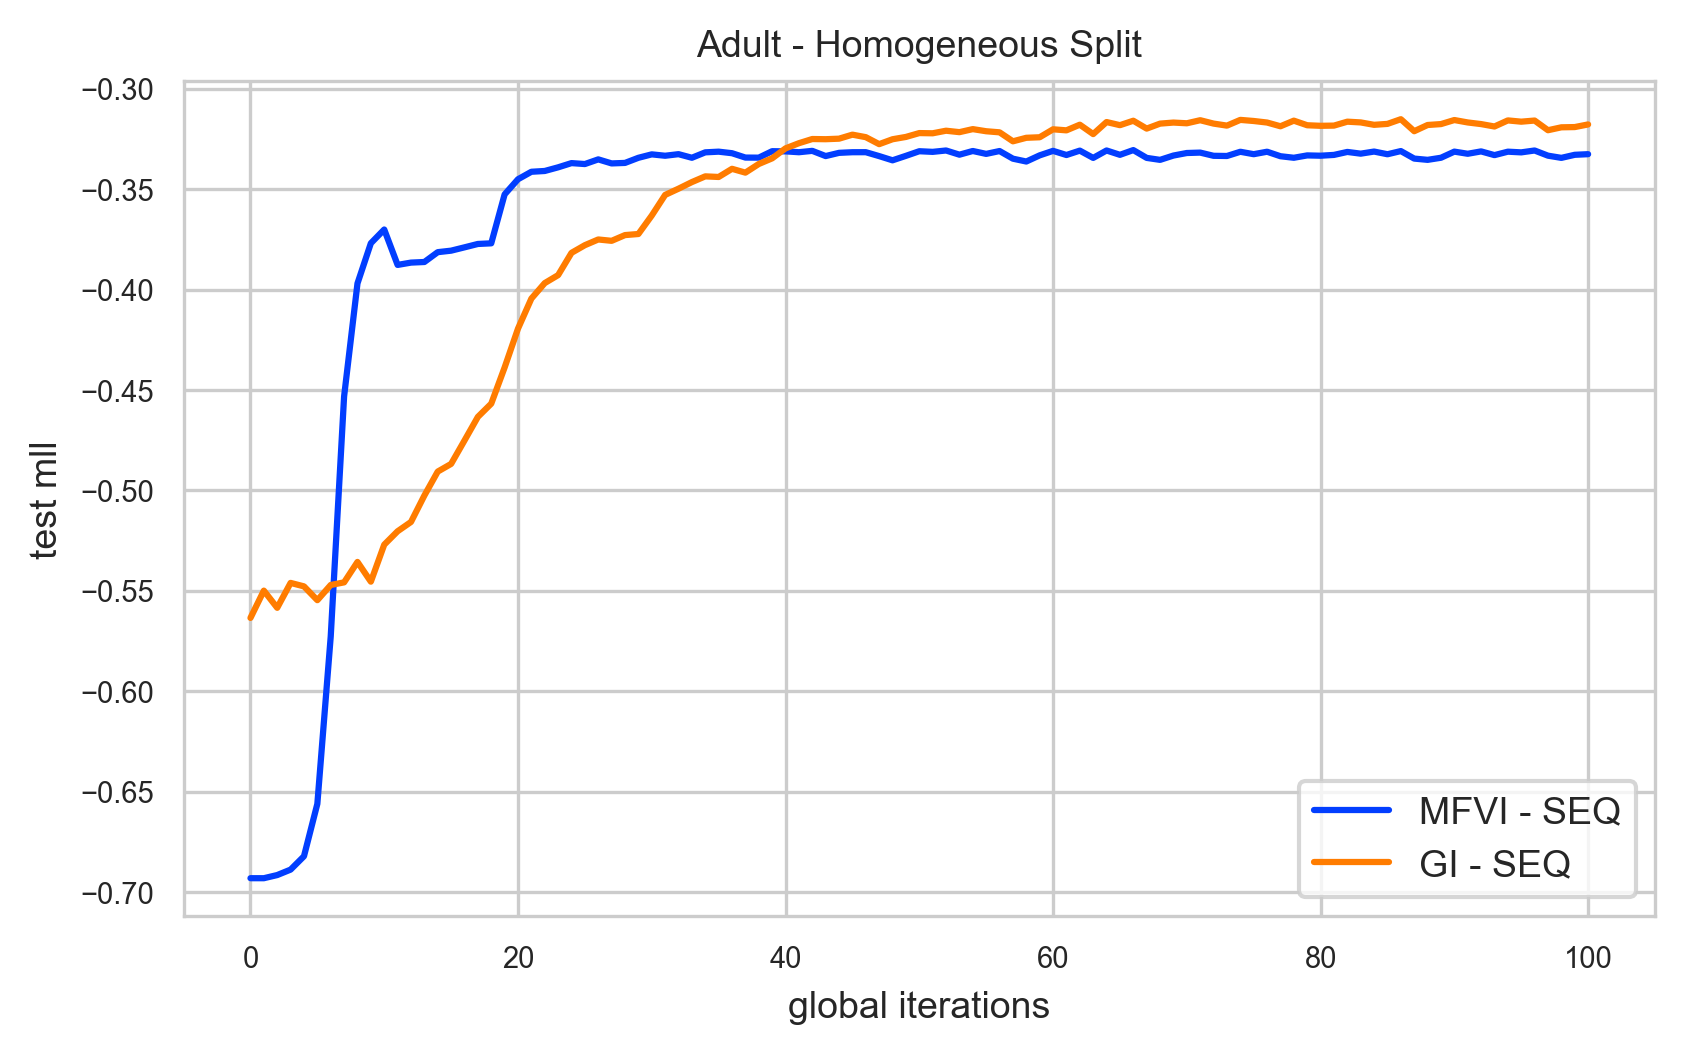

In [69]:

with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    for k, d in logs.items():
        server = logs[k]['server']
        sns.lineplot(x=server.iteration, y=server.test_mll, label=f'{k} - {server.pvi[0]}'.upper(), ax=ax)
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    # ax.set_ylim((-0.33, -0.315))
    ax.set_ylabel('test mll')
    ax.set_xlabel('global iterations')
    ax.legend(loc="lower right", prop={"size": 9})
    plt.show()

In [51]:
logs['mfvi']['client0']

,iteration,vfe,ll,kl,error
0,0,-0.854713,-0.693490,6299.443359,0.750000
1,49,-0.692419,-0.665633,1046.601807,0.234375
2,99,-0.429936,-0.419296,415.734924,0.257812
3,149,-0.420759,-0.409542,438.278198,0.289062
4,199,-0.462939,-0.452413,411.282654,0.312500
...,...,...,...,...,...
205,799,-0.328760,-0.315942,500.851562,0.125000
206,849,-0.296218,-0.283418,500.108307,0.132812
207,899,-0.368285,-0.355319,506.613190,0.195312
208,949,-0.275744,-0.262751,507.658356,0.132812


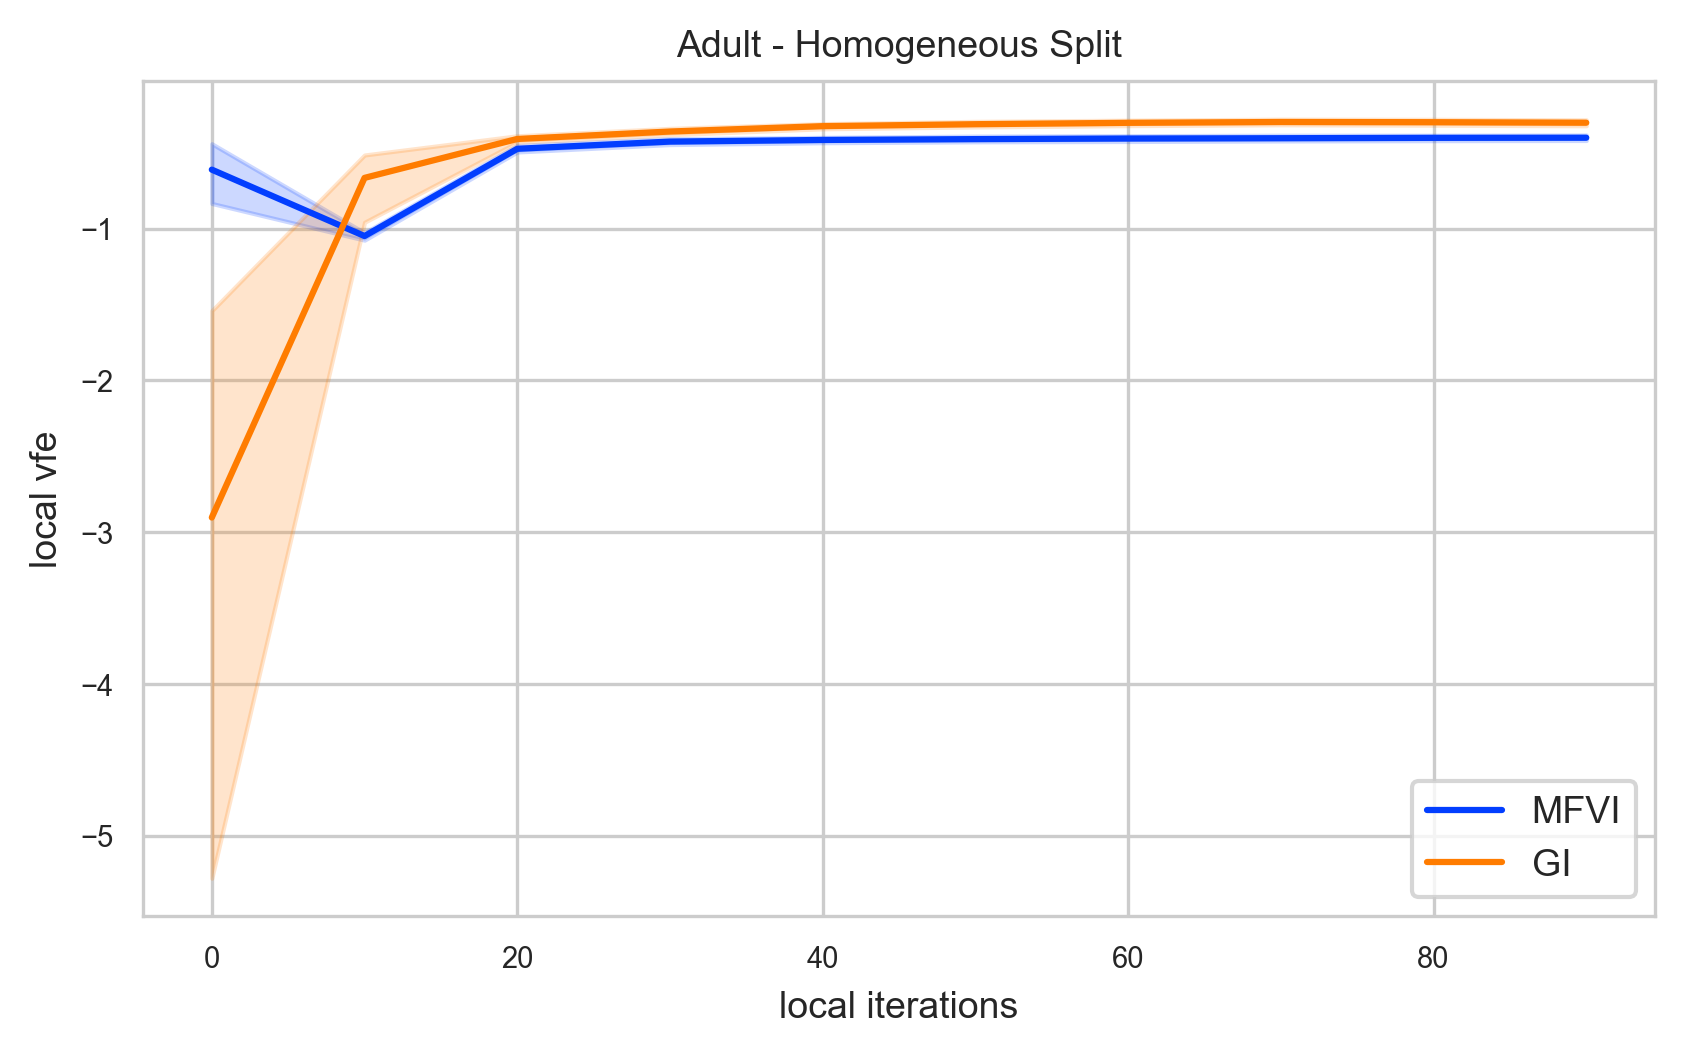

In [17]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    for k, d in logs.items():
        client0 = logs[k]['client0']
        sns.lineplot(x=client0.global_iteration, y=client0.vfe, label=f'{k}'.upper(), ax=ax)
    
    ax.set_title(f'{dataset} - Homogeneous Split - Global VI setting')
    ax.set_ylabel('local vfe')
    ax.set_xlabel('local iterations')
    ax.legend(loc="lower right", prop={"size": 9})
    plt.show()

In [8]:
# Load dictionary of vs state
# vs_path = os.path.join(exp_dir, "model/_vs.pt")
# vs_state_dict = torch.load(os.path.join(main_dir, vs_path))